In [1]:
%load_ext autoreload
%load_ext line_profiler
%autoreload 2
import sys 
from os import path as pt
import numpy as np
import matplotlib.pyplot as plt
import ot
from tqdm import tqdm

L:
[[1 0 0]
 [2 4 0]
 [3 2 1]]
A = LL^T:
[[ 1  2  3]
 [ 2 20 14]
 [ 3 14 14]]
M:
[[1 0 0]
 [2 3 0]
 [3 1 2]]
B = MM^T:
[[ 1  2  3]
 [ 2 13  9]
 [ 3  9 14]]


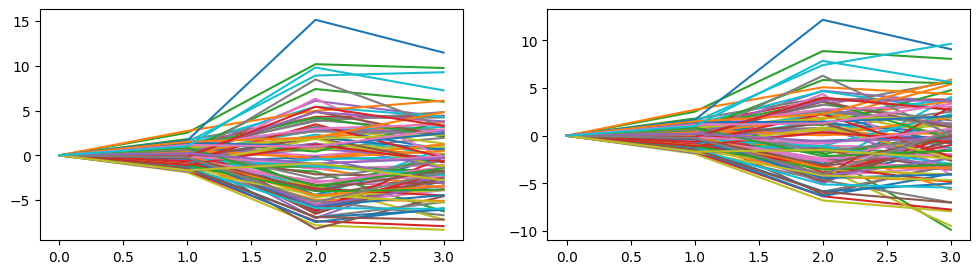

In [2]:
# Non-Markovian
# Initialize samples

T = 4 # The first time is always 0, so the non trivial timestep is T-1 here
n_sample = 500
normalize = False

L0 = np.array([[1, 0, 0], [2, 4, 0], [3, 2, 1]])
A0 = L0 @ L0.T  # A = LL^T
L = L0 / np.sqrt(np.trace(A0)) if normalize else L0
A = L @ L.T
# np.linalg.cholesky(A) -  L

M0 = np.array([[1, 0, 0], [2, 3, 0], [3, 1, 2]])
B0 = M0 @ M0.T  # A = LL^T
M = M0 / np.sqrt(np.trace(B0)) if normalize else M0
B = M @ M.T


print('L:')
print(L)
print('A = LL^T:')
print(A)

print('M:')
print(M)
print('B = MM^T:')
print(B)

noise1 = np.random.normal(size=[T-1, n_sample])  # (dim, n_sample)
noise2 = np.random.normal(size=[T-1, n_sample])  # (dim, n_sample)
X = L @ noise1  # (dim, n_sample)
Y = M @ noise1  # (dim, n_sample)
X = np.concatenate([np.zeros_like(X[:1]), X], axis=0)
Y = np.concatenate([np.zeros_like(Y[:1]), Y], axis=0)

fig, ax = plt.subplots(1, 2, figsize=[12, 3])
ax[0].plot(X[:,:100])
ax[1].plot(Y[:,:100])
plt.show()

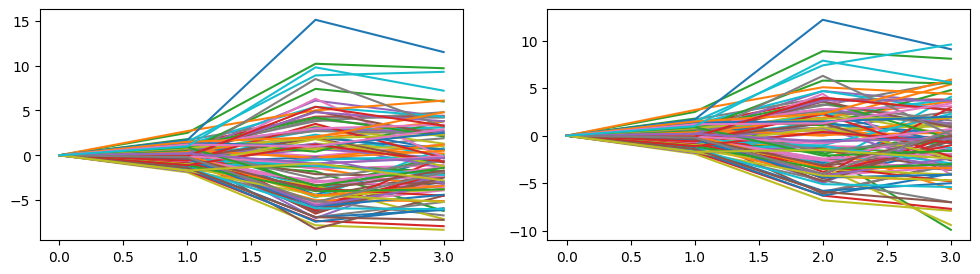

In [3]:
# Grid projection of k-mean projection
def adapted_empirical_measure(samples, delta_n):
    grid_func = lambda x: np.floor(x / delta_n + 0.5) * delta_n
    adapted_samples = grid_func(samples)
    return adapted_samples

adaptedX = adapted_empirical_measure(X, delta_n = 0.1)
adaptedY = adapted_empirical_measure(Y, delta_n = 0.1)

fig, ax = plt.subplots(1,2, figsize=[12,3])
ax[0].plot(adaptedX[:,:100])
ax[1].plot(adaptedY[:,:100])
plt.show()

In [4]:
# Quantization 
# Here I use the biggest one which works for both X and Y samples grid for simplicity.
q2v_list = np.unique(np.concatenate([adaptedX,adaptedY],axis = 0)) 
v2q_dict = {k: v for v, k in enumerate(q2v_list)}
# q2v_list, v2q_dict
len(q2v_list)

204

In [5]:
from collections import defaultdict

def path2cm(adaptedpath):
    r'''
    Path to Conditional Measure
    '''
    mu_x = [defaultdict(dict) for t in range(T-1)]
    for path in adaptedpath.T:
        for t in range(T-1):
            pre_path = tuple(v2q_dict[v] for v in path[:t+1])
            next_val = v2q_dict[path[t+1]]
            if pre_path not in mu_x[t] or next_val not in mu_x[t][pre_path]:
                mu_x[t][pre_path][next_val] = 1
            else:
                mu_x[t][pre_path][next_val] += 1
    return mu_x
mu_x = path2cm(adaptedX)
nu_y = path2cm(adaptedY)

# %lprun -f path2cm path2cm(adaptedX)

In [6]:
q2v_list_x = [list(mu_x[t].keys()) for t in range(T-1)]
v2q_dict_x = [{k: v for v, k in enumerate(q2v_list_x[t])} for t in range(T-1)]

q2v_list_y = [list(nu_y[t].keys()) for t in range(T-1)]
v2q_dict_y = [{k: v for v, k in enumerate(q2v_list_y[t])} for t in range(T-1)]

In [7]:
def nested(mu_x, nu_y, square_cost_matrix):
    T = len(mu_x)
    V = [np.zeros([len(q2v_list_x[t]),len(q2v_list_x[t])]) for t in range(T)]  # We could use sparse matrix
    for t in tqdm(range(T-1,-1,-1)):
        print(t)
        for k1,v1 in mu_x[t].items():
            for k2,v2 in nu_y[t].items():
                w1 = list(v1.values())
                w1 = np.array(w1)/sum(w1)

                w2 = list(v2.values())
                w2 = np.array(w2)/sum(w2)

                q1 = list(v1.keys())
                q2 = list(v2.keys())
                cost = square_cost_matrix[np.ix_(q1,q2)]  # sth wrong here

                if t < T-1:
                    q1s = [v2q_dict_x[t+1][k1+(q,)] for q in v1.keys()]
                    q2s = [v2q_dict_y[t+1][k2+(q,)] for q in v2.keys()]
                    cost += V[t+1][np.ix_(q1s,q2s)]
                
                V[t][v2q_dict_x[t][k1],v2q_dict_y[t][k2]] = ot.emd2(w1, w2, cost)

    AW_2square = V[0][0,0]
    return AW_2square

In [8]:
square_cost_matrix = (q2v_list[None,:] - q2v_list[None,:].T)**2
%lprun -f nested AW_2square = nested(mu_x, nu_y, square_cost_matrix)

  0%|          | 0/3 [00:00<?, ?it/s]

2


 33%|███▎      | 1/3 [00:23<00:46, 23.13s/it]

1


100%|██████████| 3/3 [00:23<00:00,  7.83s/it]

0


Timer unit: 1e-09 s

Total time: 23.1163 s
File: /var/folders/gq/bts52kyn0v72cpz5c5489984006lvv/T/ipykernel_92221/3286982689.py
Function: nested at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def nested(mu_x, nu_y, square_cost_matrix):
     2         1          0.0      0.0      0.0      T = len(mu_x)
     3         1     156000.0 156000.0      0.0      V = [np.zeros([len(q2v_list_x[t]),len(q2v_list_x[t])]) for t in range(T)]  # We could use sparse matrix
     4         4   13775000.0    3e+06      0.1      for t in tqdm(range(T-1,-1,-1)):
     5         3      51000.0  17000.0      0.0          print(t)
     6       536     448000.0    835.8      0.0          for k1,v1 in mu_x[t].items():
     7    230978   44691000.0    193.5      0.2              for k2,v2 in nu_y[t].items():
     8    230445   94680000.0    410.9      0.4                  w1 = list(v1.values())
     9    230445  314881000.0   1366.4      1.

In [9]:
def adapted_wasserstein_squared(a, A, b, B):
    # Cholesky decompositions: A = L L^T, B = M M^T
    L = np.linalg.cholesky(A)
    M = np.linalg.cholesky(B)
    # Mean squared difference
    mean_diff = np.sum((a - b) ** 2)
    # Trace terms
    trace_sum = np.trace(A) + np.trace(B)
    # L1 norm of diagonal elements of L^T M
    l1_diag = np.sum(np.abs(np.diag(L.T @ M)))
    # Final adapted Wasserstein squared distance
    return mean_diff + trace_sum - 2 * l1_diag

a, b  = np.zeros([3]), np.zeros([3])
dist_bench = adapted_wasserstein_squared(a,A,b,B)
print('Theoretical AW_2^2: ', dist_bench)
print('Numerical AW_2^2: ', AW_2square)

Theoretical AW_2^2:  3.0
Numerical AW_2^2:  3.140200000000001
